In [50]:
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from io import BytesIO
from PIL import Image
from ipywidgets import FileUpload, VBox, Output
from IPython.display import display


In [51]:
# resize zdjecia, a nastepnie ustawienie obszaru ktorym jestesmy zaintetesowani (odciebie czerwonosci), to co sie kwalifikuje pod kolor czerwony jest brane za truskawke i znakowane jako biale, a to co nie jako czarne (szum)
def extract_strawberry(img):
    img = cv2.resize(img, (128, 128))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    mask = cv2.inRange(hsv, lower_red1, upper_red1) + \
           cv2.inRange(hsv, lower_red2, upper_red2)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    strawberry = cv2.bitwise_and(img, img, mask=mask)
    return strawberry, mask


In [52]:
def color_histogram(hsv, mask, bins=8):
    h, s, v = cv2.split(hsv)

    hist_h = cv2.calcHist([h], [0], mask, [bins], [0, 180])
    hist_s = cv2.calcHist([s], [0], mask, [bins], [0, 256])
    hist_v = cv2.calcHist([v], [0], mask, [bins], [0, 256])

    hist = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    hist /= (np.sum(hist) + 1e-6)

    return hist

In [53]:
radius = 3
n_points = 8 * radius
METHOD = 'uniform'

def extract_features(img):
    strawberry, mask = extract_strawberry(img)
    mask_pixels = mask > 0

    if np.sum(mask_pixels) < 100:
        return None

    hsv = cv2.cvtColor(strawberry, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(strawberry, cv2.COLOR_BGR2GRAY)

    mean_color = np.mean(strawberry[mask_pixels], axis=0)
    color_std = np.std(strawberry[mask_pixels], axis=0)
    mean_hsv = np.mean(hsv[mask_pixels], axis=0)
    lbp = local_binary_pattern(gray, n_points, radius, METHOD)
    lbp_masked = lbp[mask_pixels]

    
    texture, _ = np.histogram(lbp_masked, bins=np.arange(0, n_points + 3), density=True)
    red_ratio = mean_color[2] / (mean_color[1] + 1)
    hist = color_histogram(hsv, mask)

    feat = np.hstack([
        mean_color,
        color_std,
        mean_hsv,
        texture,
        red_ratio,
        hist
    ])

    return feat

In [54]:
def load_images_from_folder(folder, label):
    features, labels = [], []

    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        if img is None:
            continue

        feat = extract_features(img)
        if feat is None:
            continue

        features.append(feat)
        labels.append(label)

    return features, labels


In [55]:
#random forest klasyfikator
fresh_path = "data/fresh"
rotten_path = "data/rotten"

X1, y1 = load_images_from_folder(fresh_path, 0)
X2, y2 = load_images_from_folder(rotten_path, 1)

X = np.vstack([X1, X2])
y = np.hstack([y1, y2])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

model = RandomForestClassifier(\
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

joblib.dump(model, "best_model.pkl")
print("Model zapisany jako best_model.pkl")

#metryki


Accuracy: 0.8590604026845637
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        75
           1       0.86      0.85      0.86        74

    accuracy                           0.86       149
   macro avg       0.86      0.86      0.86       149
weighted avg       0.86      0.86      0.86       149

Model zapisany jako best_model.pkl


<Figure size 500x500 with 0 Axes>

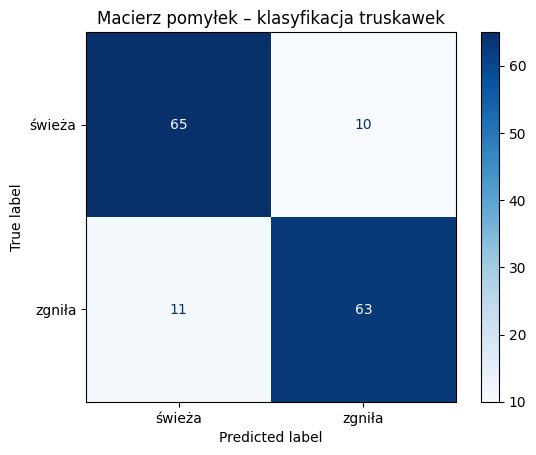

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["świeża", "zgniła"]
)

plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Macierz pomyłek – klasyfikacja truskawek")
plt.show()


Układ macierzy:
TN	FP
FN	TP

Model dobrze rozpoznaje świeże truskawki
Co czwarta zgniła truskawka przechodzi jako świeża

In [57]:
model = joblib.load("best_model.pkl")
CLASS_NAMES = ["świeża", "zgniła"]

uploader = FileUpload(accept="image/*", multiple=False)
output = Output()

def on_upload_change(change):
    output.clear_output()

    for f in uploader.value:
        img_pil = Image.open(BytesIO(f["content"])).convert("RGB")
        img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

        feat = extract_features(img)
        if feat is None:
            print("Nie wykryto truskawki!")
            return

        pred = model.predict([feat])[0]
        prob = model.predict_proba([feat])[0][pred]

        strawberry, mask = extract_strawberry(img)

        with output:
            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.imshow(img_pil)
            plt.title("Oryginał")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(mask, cmap="gray")
            plt.title("Maska")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(cv2.cvtColor(strawberry, cv2.COLOR_BGR2RGB))
            plt.title("Truskawka")
            plt.axis("off")

            plt.show()

            print(f"Predykcja: {CLASS_NAMES[pred]}")
            print(f"Pewność: {prob:.2%}")

uploader.observe(on_upload_change, names="value")
display(VBox([uploader, output]))
